In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import csv
import re

from scipy.spatial import distance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error

from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors as rdescriptors
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Scaffolds import MurckoScaffold

from matplotlib import pyplot
from itertools import chain
from IPython.core.display import SVG, HTML
from io import BytesIO
import base64

# Načtení dat

In [2]:
df = pd.read_csv('./cannabinoid_receptor_data.csv', delimiter = ";")
df = df[['Molecule ChEMBL ID', 'Molecular Weight', 'pChEMBL Value', 'Smiles']]

In [3]:
smiles = df["Smiles"]
smiles.fillna("", inplace = True)
molecules = [Chem.MolFromSmiles(smile) for smile in smiles]
df["Molecule"] = molecules

In [4]:
df.head()

,Molecule ChEMBL ID,Molecular Weight,pChEMBL Value,Smiles,Molecule
0,CHEMBL294472,384.56,7.01,CCCCCCC(C)(C)c1cc(O)c2c(c1)OC(C)(C)[C@H]1CC=C(...,<rdkit.Chem.rdchem.Mol object at 0x7f4224bd43a0>
1,CHEMBL3596747,343.42,NaN,CCOC(=O)CNC(=O)CCCCCOc1ccc2ccccc2c1,<rdkit.Chem.rdchem.Mol object at 0x7f4224bd4490>
2,CHEMBL3596749,297.40,NaN,O=C(CCCCCOc1cccc2ccccc12)NC1CC1,<rdkit.Chem.rdchem.Mol object at 0x7f4224bd43f0>
3,CHEMBL3596757,294.35,NaN,CCNC(=O)NCCCCCOc1ccc2c(c1)OCO2,<rdkit.Chem.rdchem.Mol object at 0x7f4224bd4300>
4,CHEMBL239703,551.84,6.82,O=C(NN1CCOCC1)C1=NN(c2ccc(Cl)cc2Cl)C(c2ccc(Cl)...,<rdkit.Chem.rdchem.Mol object at 0x7f4224bd42b0>


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992 entries, 0 to 5991
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecule ChEMBL ID  5992 non-null   object 
 1   Molecular Weight    5992 non-null   object 
 2   pChEMBL Value       3667 non-null   float64
 3   Smiles              5992 non-null   object 
 4   Molecule            5992 non-null   object 
dtypes: float64(1), object(4)
memory usage: 234.2+ KB


# Standardizace

In [6]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [7]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

In [8]:
df = df.replace(['NaN', 'None', ''], float('nan'))
df = df.dropna()

In [9]:
df['Molecule'] = df['Molecule'].apply(standardize)

In [10]:
structures = df['Molecule']

In [11]:
print(len(structures))

3666


In [12]:
structures

0       <rdkit.Chem.rdchem.Mol object at 0x7f4224a99df0>
4       <rdkit.Chem.rdchem.Mol object at 0x7f4224ab68f0>
6       <rdkit.Chem.rdchem.Mol object at 0x7f4224ab6d50>
9       <rdkit.Chem.rdchem.Mol object at 0x7f4224ab9260>
10      <rdkit.Chem.rdchem.Mol object at 0x7f4224ab9710>
                              ...                       
5986    <rdkit.Chem.rdchem.Mol object at 0x7f4224a3cb20>
5988    <rdkit.Chem.rdchem.Mol object at 0x7f4224a39620>
5989    <rdkit.Chem.rdchem.Mol object at 0x7f4224a402b0>
5990    <rdkit.Chem.rdchem.Mol object at 0x7f4224a40620>
5991    <rdkit.Chem.rdchem.Mol object at 0x7f4224a39350>
Name: Molecule, Length: 3666, dtype: object

# Drug-likeness

In [13]:
def lipinsky(molecule):
    if rdescriptors.CalcNumLipinskiHBD(molecule) <= 5 and rdescriptors.CalcNumLipinskiHBA(molecule) <= 10 \
    and rdescriptors.CalcExactMolWt(molecule) <= 500 and Descriptors.MolLogP(molecule) <= 5:
        return True
    else:
        return False

In [14]:
druglike = []
for structure in structures:
    if structure == None:
        continue
    if lipinsky(structure):
        druglike.append(structure)

In [15]:
print(len(druglike))

1218


In [16]:
print(len(structures))

3666


**Z celkového počtu 3666 struktur je jich 1218 drug-like.**

# PAINs

In [17]:
pains = []
with open('./pains/p_l15.txt', 'r') as f, open('./pains/p_m150.txt', 'r') as p:
    for line in chain(f, p):
        pattern, text = line.strip().split('\t') # split by tab
        pains.append([Chem.MolFromSmarts(pattern),
                      text.lstrip("<regId=\"").rstrip("\">")]) # remove the xml tags
pains, len(pains)

([[<rdkit.Chem.rdchem.Mol at 0x7f4224a998f0>, 'anil_di_alk_F(14)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f4224a2f7b0>, 'hzone_anil(14)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f4224a99b20>, 'het_5_pyrazole_OH(14)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f4224a31e90>, 'het_thio_666_A(13)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f4224a312b0>, 'styrene_A(13)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f4224a364e0>, 'ne_rhod_C(13)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f4224a36da0>, 'hp_amino_CN_A(13)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f4224a6f170>, 'cyano_imine_C(12)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f4224a6f5d0>, 'thio_urea_A(12)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f4224a6bcb0>, 'thiophene_amino_B(12)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f4224a3a300>, 'keto_keto_beta_B(12)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f4224a3abc0>, 'keto_phenone_A(11)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f4224a6c8f0>, 'cyano_pyridone_C(11)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f4224a30c10>, 'thiaz_ene_C(11)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f4224a3c0d0>, '

In [18]:
for mol in druglike:
    mol.pain_hits = [i for i, pain in enumerate(pains) if mol.HasSubstructMatch(pain[0])]

mols_with_pains = [m for m in druglike if m.pain_hits]
len(mols_with_pains)

11

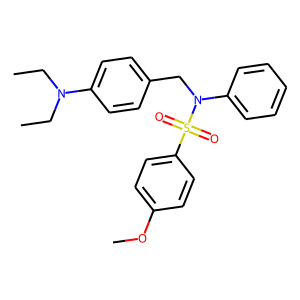

In [19]:
Draw.MolToImage(mols_with_pains[0])

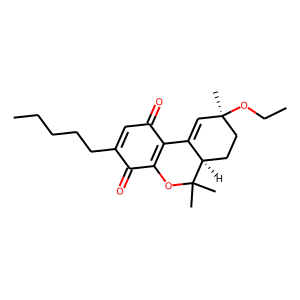

In [20]:
Draw.MolToImage(mols_with_pains[10])

**11 struktur jsem se rozhodla vyfiltrovat.**

In [21]:
druglike_no_pains = [m for m in druglike if not m.pain_hits]
print(len(druglike_no_pains))

1207


In [22]:
data = df[df['Molecule'].isin(druglike_no_pains)]

In [23]:
data.head()

,Molecule ChEMBL ID,Molecular Weight,pChEMBL Value,Smiles,Molecule
4,CHEMBL239703,551.84,6.82,O=C(NN1CCOCC1)C1=NN(c2ccc(Cl)cc2Cl)C(c2ccc(Cl)...,<rdkit.Chem.rdchem.Mol object at 0x7f4224ab68f0>
6,CHEMBL250769,397.52,6.54,O=C(NC1CCCCCC1)c1cn(CCN2CCOCC2)c2ccccc2c1=O,<rdkit.Chem.rdchem.Mol object at 0x7f4224ab6d50>
9,CHEMBL255096,420.58,7.30,Cc1ccc(C(=O)N[C@H]2CC3CC[C@@]2(C)C3(C)C)cc1S(=...,<rdkit.Chem.rdchem.Mol object at 0x7f4224ab9260>
13,CHEMBL272868,383.49,7.55,CC1(C)C(C(=O)c2cn(CC3CCOCC3)c3cc4c(cc23)OCO4)C...,<rdkit.Chem.rdchem.Mol object at 0x7f4224ab9bc0>
15,CHEMBL269851,369.51,7.40,COc1ccc2c(C(=O)C3C(C)(C)C3(C)C)cn(CC3CCOCC3)c2c1,<rdkit.Chem.rdchem.Mol object at 0x7f4224aba580>


# MQN

In [24]:
MQN = pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in data["Molecule"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))]) 

In [25]:
y = np.array(data['pChEMBL Value']).ravel()
x = np.array(MQN)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

## Random Forest

In [26]:
RF_model = ensemble.RandomForestRegressor(random_state=1)
RF_model.fit(X_train, y_train)
RF_prediction = RF_model.predict(X_test)

Text(0.5, 1.0, 'Random Forest')

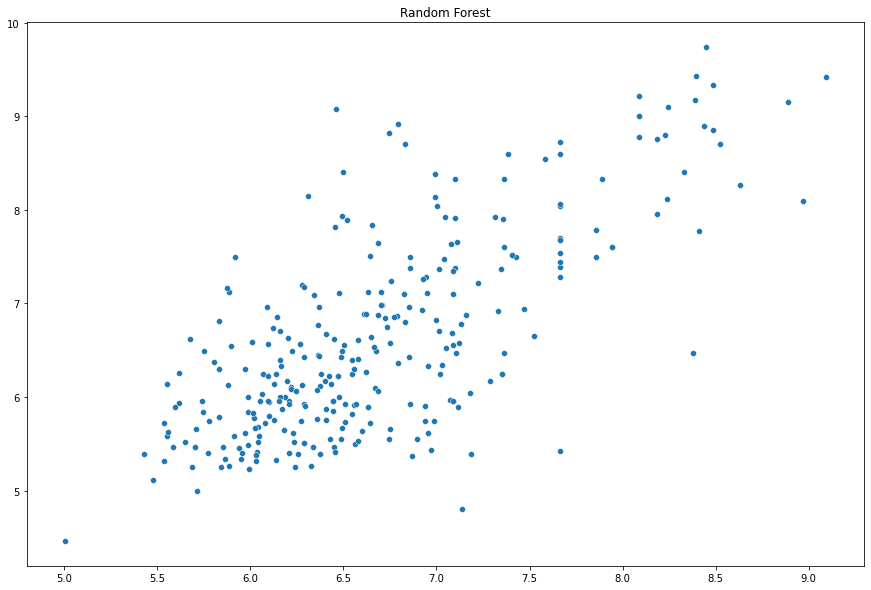

In [27]:
fig, axs = plt.subplots(figsize=(15, 10))
sns.scatterplot(x = RF_prediction.ravel(), y = y_test.ravel()).set_title('Random Forest')

## KNeighbours

In [28]:
Kn_model = neighbors.KNeighborsRegressor()
Kn_model.fit(X_train, y_train)
Kn_prediction = Kn_model.predict(X_test)

Text(0.5, 1.0, 'KNeighbours')

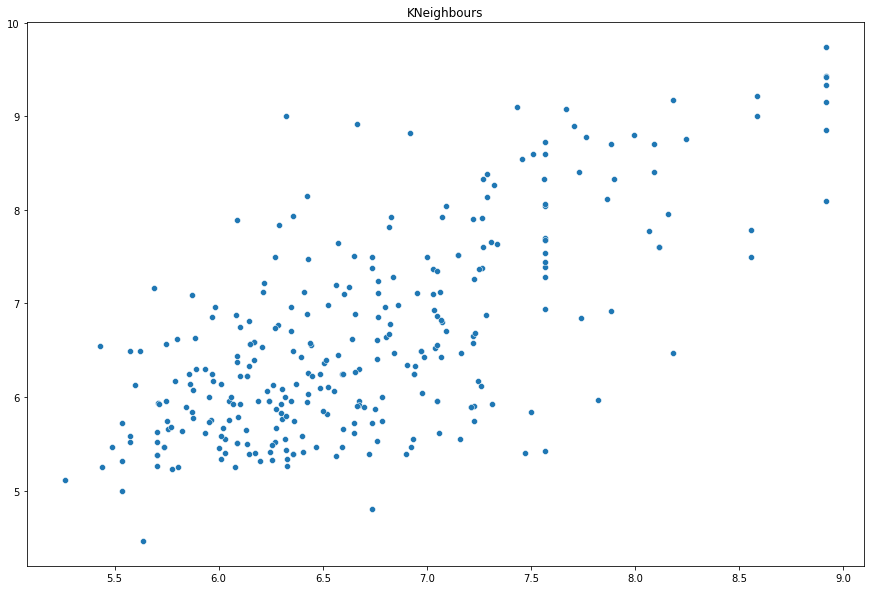

In [29]:
fig, axs = plt.subplots(figsize=(15, 10))
sns.scatterplot(x = Kn_prediction.ravel(), y = y_test.ravel()).set_title('KNeighbours')

## Linear Regression

In [30]:
LR_model = linear_model.LinearRegression()
LR_model.fit(X_train, y_train)
LR_prediction = LR_model.predict(X_test)

Text(0.5, 1.0, 'Linear Regression')

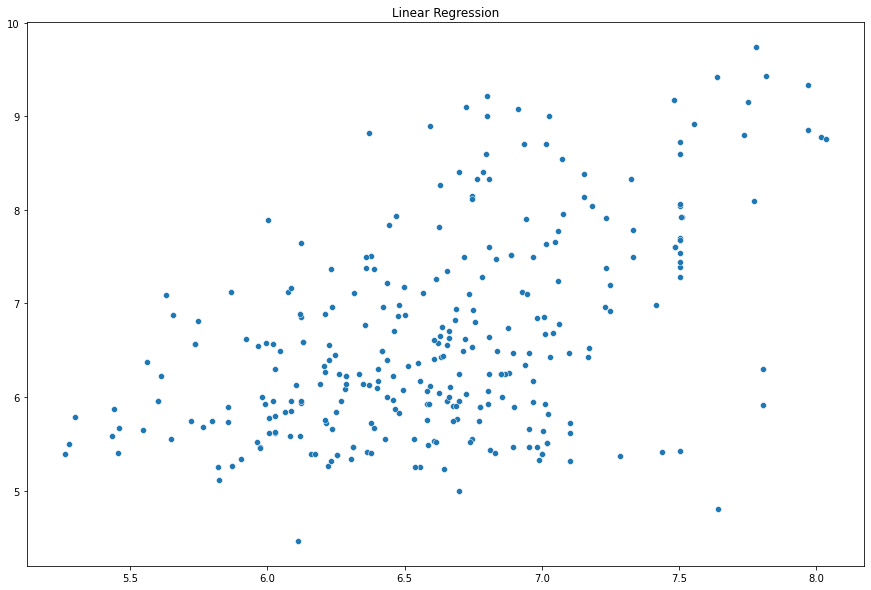

In [31]:
fig, axs = plt.subplots(figsize=(15, 10))
sns.scatterplot(x = LR_prediction.ravel(), y = y_test.ravel()).set_title('Linear Regression')

# Drugbank

In [32]:
drugbank = [m for m in Chem.SDMolSupplier('./drugbank.sdf') if m]
smiles = [Chem.MolToSmiles(m) if m is not None else np.nan() for m in drugbank]
molweight = [Descriptors.ExactMolWt(m) if m is not None else np.nan() for m in drugbank]

RDKit ERROR: [11:11:41] Explicit valence for atom # 7 N, 4, is greater than permitted
[11:11:41] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [11:11:41] ERROR: Could not sanitize molecule ending on line 20009
[11:11:41] ERROR: Could not sanitize molecule ending on line 20009
RDKit ERROR: [11:11:41] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[11:11:41] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[11:11:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10

RDKit ERROR: [11:11:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [11:11:41] ERROR: Could not sanitize molecule ending on line 250947
[11:11:41] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [11:11:41] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [11:11:41] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: 

[11:11:41] ERROR: Could not sanitize molecule ending on line 347574
RDKit ERROR: [11:11:41] ERROR: Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:11:41] ERROR: Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7

[11:11:41] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13

RDKit ERROR: 
RDKit ERROR: [11:11:41] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [11:11:41] ERROR: Could not sanitize molecule ending on line 357505
[11:11:41] ERROR: Could not sanitize molecule ending on line 357505
RDKit ERROR: [11:11:41] ERROR: Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[11:11:41] ERROR: Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13

[11:11:41] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7

RDKit ERROR: 
RDKit ERROR: [11:11:41] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit ERROR: 
RDKit ERROR: [11:11:41] ERROR: Could not sanitize molecule ending on line 371006
[11:11:41] ERROR: Could no

RDKit ERROR: [11:11:42] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[11:11:42] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9

[11:11:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 10

RDKit ERROR: 
RDKit ERROR: [11:11:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 10
RDKit ERROR: 
RDKit ERROR: [11:11:42] ERROR: Could not sanitize molecule ending on line 511111
[11:11:42] ERROR: Could not sanitize molecule ending on line 511111
RDKit ERROR: [11:11:42] ERROR: Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 10
[11:11:42] ERROR: Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 10

[11:11:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10

RDKit ERROR: 
RDKit ERROR: [11:11:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [11:11:42] ERROR: Could not sanitize molecule ending on line 512030
[11:11:42] ERROR: Could not sanitize molecule ending on line 512030
RDKit ERROR: [11:11:

RDKit ERROR: [11:11:42] ERROR: Explicit valence for atom # 17 Mg, 4, is greater than permitted
[11:11:42] ERROR: Explicit valence for atom # 17 Mg, 4, is greater than permitted
[11:11:42] Explicit valence for atom # 4 F, 2, is greater than permitted
RDKit ERROR: [11:11:42] Explicit valence for atom # 4 F, 2, is greater than permitted
RDKit ERROR: [11:11:42] ERROR: Could not sanitize molecule ending on line 645068
[11:11:42] ERROR: Could not sanitize molecule ending on line 645068
RDKit ERROR: [11:11:42] ERROR: Explicit valence for atom # 4 F, 2, is greater than permitted
[11:11:42] ERROR: Explicit valence for atom # 4 F, 2, is greater than permitted
[11:11:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10

RDKit ERROR: [11:11:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [11:11:42] ERROR: Could not sanitize molecule ending on line 659994
[11:11:42] ERROR: Could not sanitize molecule ending on line 659994
RDKit ERROR: [11:11:4

In [33]:
temp = {'Smiles': smiles, 'Molecular Weight': molweight, 'Molecule': drugbank}
drugbank_df = pd.DataFrame(data = temp)

In [34]:
drugbank_df.head()

,Smiles,Molecular Weight,Molecule
0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,2178.985813,<rdkit.Chem.rdchem.Mol object at 0x7f4224076710>
1,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,1268.641439,<rdkit.Chem.rdchem.Mol object at 0x7f4223ffe210>
2,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,1068.426955,<rdkit.Chem.rdchem.Mol object at 0x7f4223ffed50>
3,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,1429.669818,<rdkit.Chem.rdchem.Mol object at 0x7f4223ffe3a0>
4,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,1201.841368,<rdkit.Chem.rdchem.Mol object at 0x7f4223ffe990>


In [35]:
MQN_drugbank = pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in drugbank_df["Molecule"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))]) 

In [36]:
RF_prediction = RF_model.predict(MQN_drugbank)

/home/martina/miniconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [37]:
RF_prediction

array([7.04226667, 7.33191667, 6.88537   , ..., 7.19378333, 5.75048667,
       6.28750889])

In [38]:
drugbank_df['pChEMBL Value'] = RF_prediction
drugbank_df['Activity'] = False
drugbank_df.loc[drugbank_df['pChEMBL Value'] > 7, 'Activity'] = True

In [39]:
data['Activity'] = False
data.loc[data['pChEMBL Value'] > 7, 'Activity'] = True

/home/martina/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/martina/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [40]:
drugbank_df.head()

,Smiles,Molecular Weight,Molecule,pChEMBL Value,Activity
0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,2178.985813,<rdkit.Chem.rdchem.Mol object at 0x7f4224076710>,7.042267,True
1,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,1268.641439,<rdkit.Chem.rdchem.Mol object at 0x7f4223ffe210>,7.331917,True
2,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,1068.426955,<rdkit.Chem.rdchem.Mol object at 0x7f4223ffed50>,6.885370,False
3,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,1429.669818,<rdkit.Chem.rdchem.Mol object at 0x7f4223ffe3a0>,7.267382,True
4,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,1201.841368,<rdkit.Chem.rdchem.Mol object at 0x7f4223ffe990>,7.001300,True


In [41]:
drugbank_df['Activity'].value_counts()

False    6331
True      784
Name: Activity, dtype: int64

In [42]:
drugbank_df['Source'] = 'Drugbank'
data['Source'] = 'Cannabinoid'
all_data = data.append(drugbank_df, ignore_index = True)

/home/martina/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
all_data.head()

,Molecule ChEMBL ID,Molecular Weight,pChEMBL Value,Smiles,Molecule,Activity,Source
0,CHEMBL239703,551.84,6.82,O=C(NN1CCOCC1)C1=NN(c2ccc(Cl)cc2Cl)C(c2ccc(Cl)...,<rdkit.Chem.rdchem.Mol object at 0x7f4224ab68f0>,False,Cannabinoid
1,CHEMBL250769,397.52,6.54,O=C(NC1CCCCCC1)c1cn(CCN2CCOCC2)c2ccccc2c1=O,<rdkit.Chem.rdchem.Mol object at 0x7f4224ab6d50>,False,Cannabinoid
2,CHEMBL255096,420.58,7.30,Cc1ccc(C(=O)N[C@H]2CC3CC[C@@]2(C)C3(C)C)cc1S(=...,<rdkit.Chem.rdchem.Mol object at 0x7f4224ab9260>,True,Cannabinoid
3,CHEMBL272868,383.49,7.55,CC1(C)C(C(=O)c2cn(CC3CCOCC3)c3cc4c(cc23)OCO4)C...,<rdkit.Chem.rdchem.Mol object at 0x7f4224ab9bc0>,True,Cannabinoid
4,CHEMBL269851,369.51,7.40,COc1ccc2c(C(=O)C3C(C)(C)C3(C)C)cn(CC3CCOCC3)c2c1,<rdkit.Chem.rdchem.Mol object at 0x7f4224aba580>,True,Cannabinoid


# Vizualizace

In [44]:
df = all_data.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in all_data['Molecule']),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

In [45]:
fingerprint = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits = 1024) for m in all_data['Molecule']]
df['Fingerprints'] = fingerprint

In [46]:
df.tail()

,Molecule ChEMBL ID,Molecular Weight,pChEMBL Value,Smiles,Molecule,Activity,Source,MQN_1,MQN_2,MQN_3,...,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42,Fingerprints
8317,NaN,128.002892,5.631150,Oc1ccc(Cl)cc1,<rdkit.Chem.rdchem.Mol object at 0x7f4223fb3990>,False,Drugbank,6,0,1,...,0,0,1,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8318,NaN,340.079432,6.546725,O=c1ccc2cc(O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)...,<rdkit.Chem.rdchem.Mol object at 0x7f4223fb39e0>,False,Drugbank,15,0,0,...,0,0,3,0,0,0,0,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
8319,NaN,1114.554641,7.193783,CC(=O)Nc1ccc(C(=O)O)cc1.CC(=O)Nc1ccc(C(=O)O)cc...,<rdkit.Chem.rdchem.Mol object at 0x7f4223fb3a30>,True,Drugbank,52,0,0,...,0,2,4,0,0,0,0,2,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8320,NaN,330.147689,5.750487,CCCCCCCCCCCCOC(=O)CS(=O)(=O)[O-].[Na+],<rdkit.Chem.rdchem.Mol object at 0x7f4223fb3a80>,False,Drugbank,14,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ..."
8321,NaN,408.150365,6.287509,C[C@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@...,<rdkit.Chem.rdchem.Mol object at 0x7f4223fb3ad0>,False,Drugbank,22,1,1,...,0,1,3,0,0,0,0,6,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


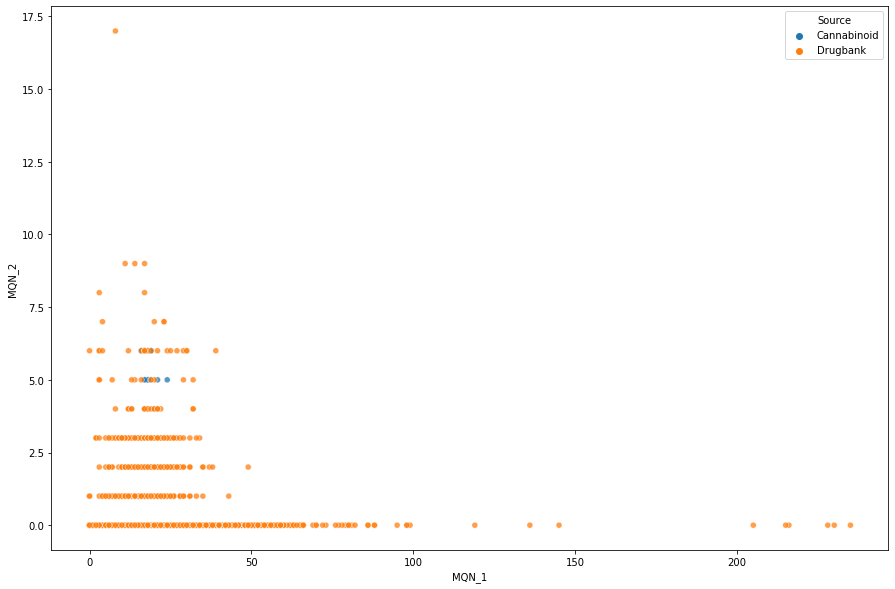

In [47]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=sns.scatterplot(x="MQN_1",
                      y="MQN_2",
                      data=df,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## PCA

In [48]:
pca = decomposition.PCA(n_components=42)
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca.fit(norm)
df = all_data.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

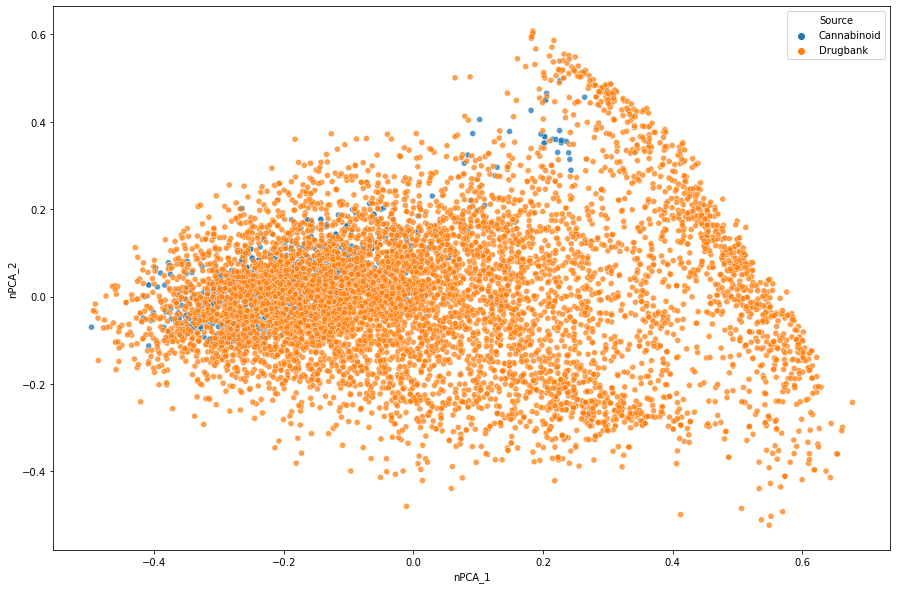

In [49]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=sns.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

# Analýza scaffoldů

In [50]:
def mol2display_png(mol):
    """Format RDKit mol for direct inline display. The most convenient, probably."""
    d2d = rdMolDraw2D.MolDraw2DCairo(400,400)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    buffer = BytesIO(d2d.GetDrawingText())
    return f'<img src="data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}">'

In [67]:
def mol2scaffold(mol):
    try:
        scaffold1 = MurckoScaffold.GetScaffoldForMol(mol)
        scaffold2 = MurckoScaffold.MakeScaffoldGeneric(scaffold1)
        scaffold3 = MurckoScaffold.GetScaffoldForMol(scaffold2)
    except ValueError:
        return Chem.MolFromSmiles('*')
    return scaffold3

In [52]:
drugbank = all_data.loc[all_data['Source'] == 'Drugbank']
active_drugbank = drugbank.loc[drugbank['Activity'] == True]
active_drugbank = active_drugbank.sort_values(by=['pChEMBL Value'], ascending=False)

In [53]:
active_drugbank.head()

,Molecule ChEMBL ID,Molecular Weight,pChEMBL Value,Smiles,Molecule,Activity,Source
6248,NaN,491.094951,8.243356,O=C(CN1[C@@H](O)C(NCCc2ccccn2)=NC[C@H]1Cl)NCc1...,<rdkit.Chem.rdchem.Mol object at 0x7f4223f8a3a0>,True,Drugbank
6443,NaN,462.119813,8.213525,Cn1ncc2ncnc(NCCc3cnc(NC(=O)Nc4cccc(C(F)(F)F)c4...,<rdkit.Chem.rdchem.Mol object at 0x7f4223f8e210>,True,Drugbank
6022,NaN,461.086637,8.141067,CNC(=O)c1cc(Oc2ccc3nc(Nc4ccc(Cl)c(C(F)(F)F)c4)...,<rdkit.Chem.rdchem.Mol object at 0x7f4223f85b20>,True,Drugbank
2336,NaN,487.155722,8.082433,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,<rdkit.Chem.rdchem.Mol object at 0x7f422403bf80>,True,Drugbank
5762,NaN,495.234491,8.077950,C[C@H](Cc1cc2c(c(C(N)=O)c1)N(CCCO)CC2)NCCOc1cc...,<rdkit.Chem.rdchem.Mol object at 0x7f4223f80800>,True,Drugbank


In [54]:
cannabinoid = all_data.loc[all_data['Source'] == 'Cannabinoid']
active_cannabinoid = cannabinoid.loc[cannabinoid['Activity'] == True]
active_cannabinoid = active_cannabinoid.sort_values(by=['pChEMBL Value'], ascending=False)

In [55]:
active_cannabinoid.head()

,Molecule ChEMBL ID,Molecular Weight,pChEMBL Value,Smiles,Molecule,Activity,Source
524,CHEMBL2063249,470.32,10.10,O=C(NC1CCCOc2c1nn(-c1ccccc1Cl)c2-c1ccc(Cl)cc1)...,<rdkit.Chem.rdchem.Mol object at 0x7f4224ab7f80>,True,Cannabinoid
980,CHEMBL1801352,478.92,9.74,C[C@@H](NC(=O)C1(NC(=O)c2cncnc2)CC1)c1ccc(-n2n...,<rdkit.Chem.rdchem.Mol object at 0x7f4224a22850>,True,Cannabinoid
894,CHEMBL1801346,493.93,9.52,C[C@@H](NC(=O)C1(NC(=O)c2cncc(O)c2)CC1)c1ccc(-...,<rdkit.Chem.rdchem.Mol object at 0x7f4224a2d030>,True,Cannabinoid
895,CHEMBL1801348,495.92,9.43,C[C@@H](NC(=O)C1(NC(=O)c2cncc(F)c2)CC1)c1ccc(-...,<rdkit.Chem.rdchem.Mol object at 0x7f4224a2df80>,True,Cannabinoid
936,CHEMBL1801341,466.90,9.42,C[C@@H](NC(=O)C1(NC(=O)c2cn[nH]c2)CC1)c1ccc(-n...,<rdkit.Chem.rdchem.Mol object at 0x7f4224a24580>,True,Cannabinoid


,Molecule ChEMBL ID,Molecular Weight,pChEMBL Value,Smiles,Molecule,Activity,Source
6248,NaN,491.094951,8.243356,O=C(CN1[C@@H](O)C(NCCc2ccccn2)=NC[C@H]1Cl)NCc1csc2ccc(Cl)cc12,,True,Drugbank
6443,NaN,462.119813,8.213525,Cn1ncc2ncnc(NCCc3cnc(NC(=O)Nc4cccc(C(F)(F)F)c4)s3)c21,,True,Drugbank
6022,NaN,461.086637,8.141067,CNC(=O)c1cc(Oc2ccc3nc(Nc4ccc(Cl)c(C(F)(F)F)c4)[nH]c3c2)ccn1,,True,Drugbank
2336,NaN,487.155722,8.082433,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(CCO)CC2)n1,,True,Drugbank
5762,NaN,495.234491,8.077950,C[C@H](Cc1cc2c(c(C(N)=O)c1)N(CCCO)CC2)NCCOc1ccccc1OCC(F)(F)F,,True,Drugbank

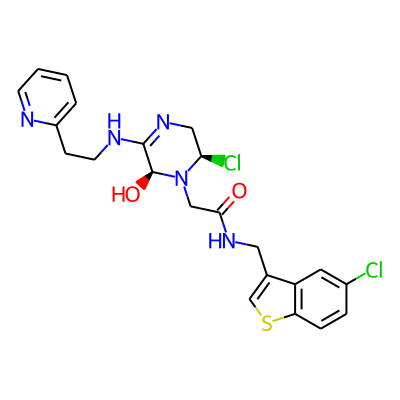
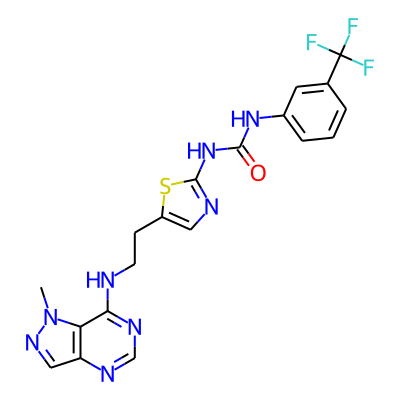
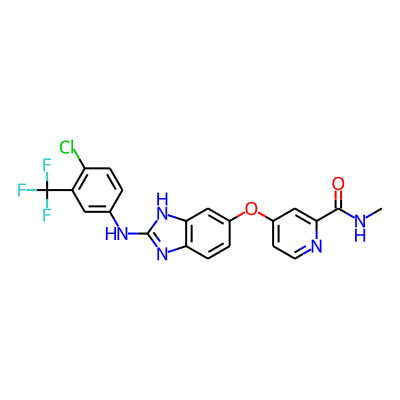
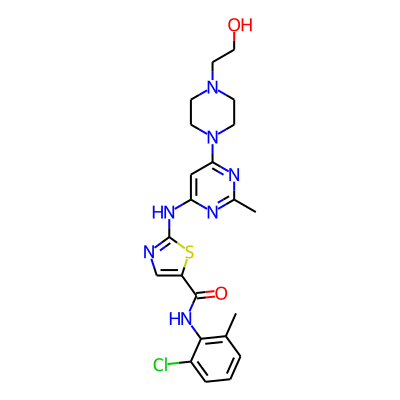
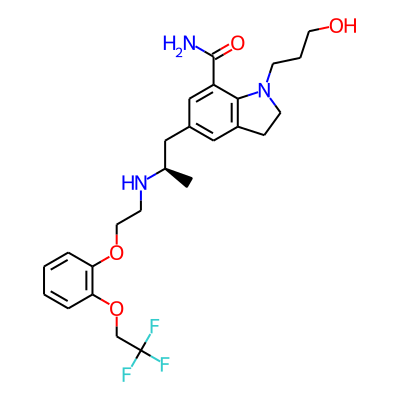

In [62]:
HTML(active_drugbank.head().to_html(formatters={'Molecule': mol2display_png}, escape=False))

,Molecule ChEMBL ID,Molecular Weight,pChEMBL Value,Smiles,Molecule,Activity,Source
524,CHEMBL2063249,470.32,10.10,O=C(NC1CCCOc2c1nn(-c1ccccc1Cl)c2-c1ccc(Cl)cc1)c1cnon1,,True,Cannabinoid
980,CHEMBL1801352,478.92,9.74,C[C@@H](NC(=O)C1(NC(=O)c2cncnc2)CC1)c1ccc(-n2nc(Cl)c3ccccc32)cc1F,,True,Cannabinoid
894,CHEMBL1801346,493.93,9.52,C[C@@H](NC(=O)C1(NC(=O)c2cncc(O)c2)CC1)c1ccc(-n2nc(Cl)c3ccccc32)cc1F,,True,Cannabinoid
895,CHEMBL1801348,495.92,9.43,C[C@@H](NC(=O)C1(NC(=O)c2cncc(F)c2)CC1)c1ccc(-n2nc(Cl)c3ccccc32)cc1F,,True,Cannabinoid
936,CHEMBL1801341,466.90,9.42,C[C@@H](NC(=O)C1(NC(=O)c2cn[nH]c2)CC1)c1ccc(-n2nc(Cl)c3ccccc32)cc1F,,True,Cannabinoid

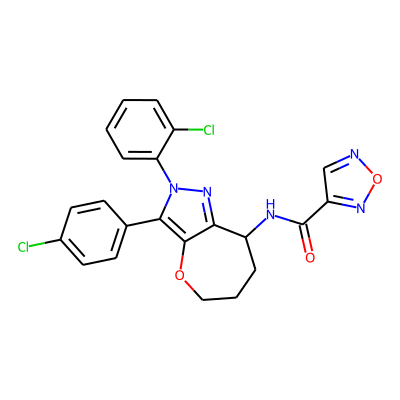
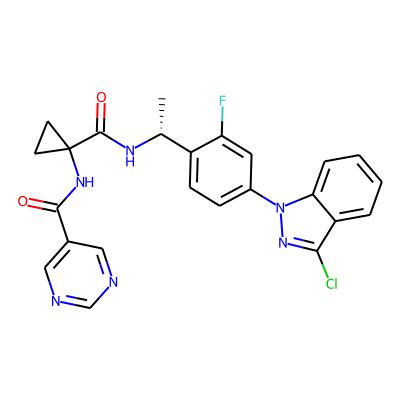
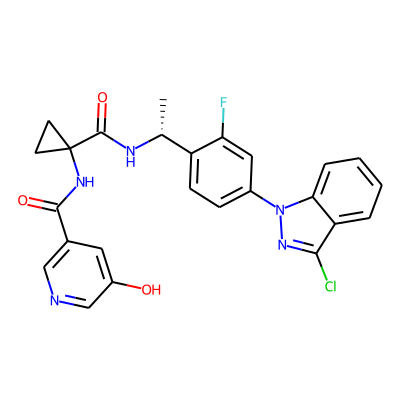
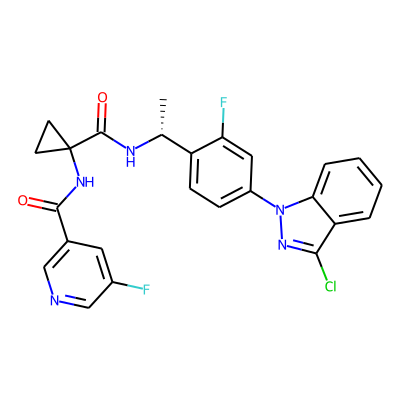
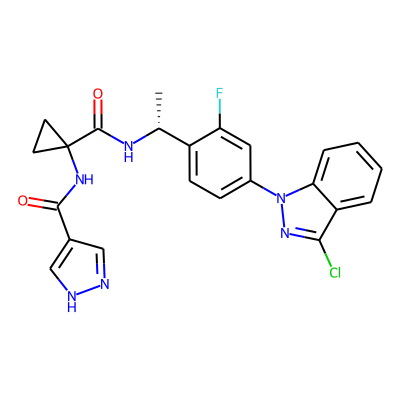

In [63]:
HTML(active_cannabinoid.head().to_html(formatters={'Molecule': mol2display_png}, escape=False))

RDKit ERROR: [11:17:53] Explicit valence for atom # 48 C, 5, is greater than permitted
[11:17:53] Explicit valence for atom # 48 C, 5, is greater than permitted
RDKit ERROR: [11:17:53] Explicit valence for atom # 28 C, 5, is greater than permitted
[11:17:53] Explicit valence for atom # 28 C, 5, is greater than permitted
RDKit ERROR: [11:17:53] Explicit valence for atom # 41 C, 5, is greater than permitted
[11:17:53] Explicit valence for atom # 41 C, 5, is greater than permitted


,Molecule ChEMBL ID,Molecular Weight,pChEMBL Value,Smiles,Molecule,Activity,Source,Scaffold,Scaffold Smiles
6248,NaN,491.094951,8.243356,O=C(CN1[C@@H](O)C(NCCc2ccccn2)=NC[C@H]1Cl)NCc1csc2ccc(Cl)cc12,,True,Drugbank,,C1CCC(CCCC2CCCC(CCCCC3CCC4CCCCC34)C2)CC1
6443,NaN,462.119813,8.213525,Cn1ncc2ncnc(NCCc3cnc(NC(=O)Nc4cccc(C(F)(F)F)c4)s3)c21,,True,Drugbank,,C1CCC(CCCC2CCC(CCCC3CCCC4CCCC34)C2)CC1
6022,NaN,461.086637,8.141067,CNC(=O)c1cc(Oc2ccc3nc(Nc4ccc(Cl)c(C(F)(F)F)c4)[nH]c3c2)ccn1,,True,Drugbank,,C1CCC(CC2CCC3CC(CC4CCCCC4)CC3C2)CC1
2336,NaN,487.155722,8.082433,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(CCO)CC2)n1,,True,Drugbank,,C1CCC(CCC2CCC(CC3CCCC(C4CCCCC4)C3)C2)CC1
5762,NaN,495.234491,8.077950,C[C@H](Cc1cc2c(c(C(N)=O)c1)N(CCCO)CC2)NCCOc1ccccc1OCC(F)(F)F,,True,Drugbank,,C(CCCC1CCC2CCCC2C1)CCC1CCCCC1

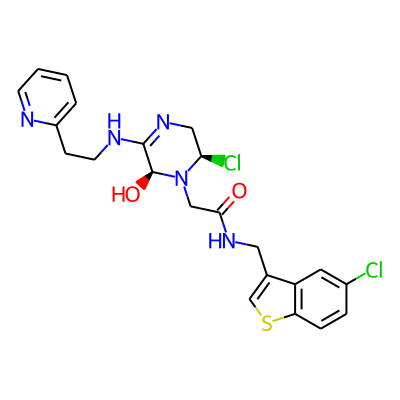
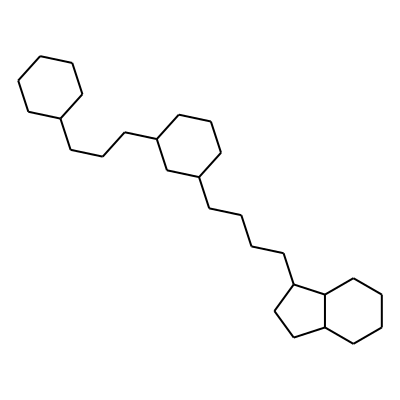
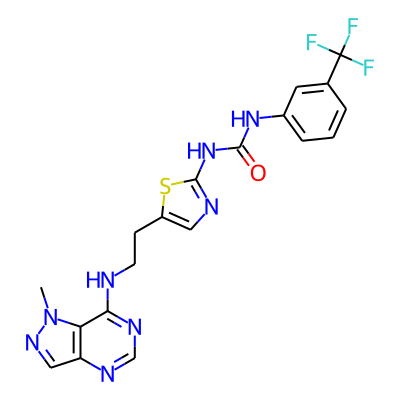
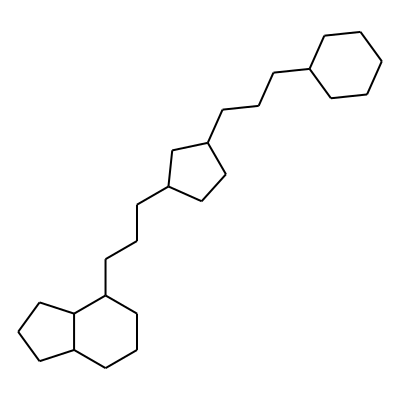
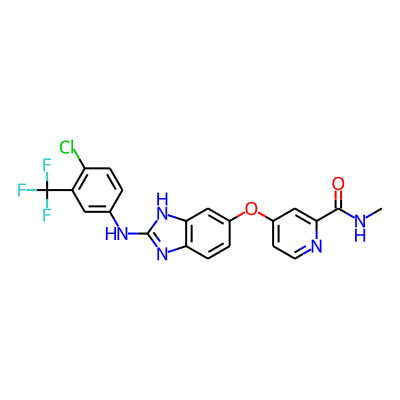
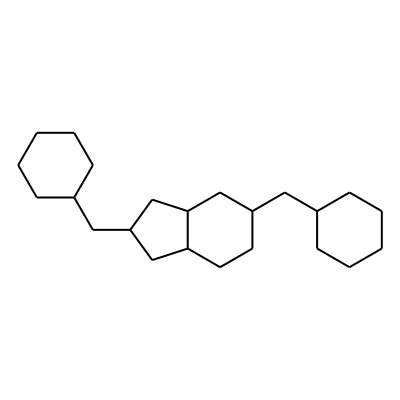
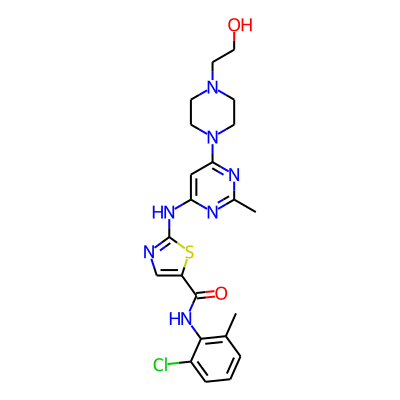
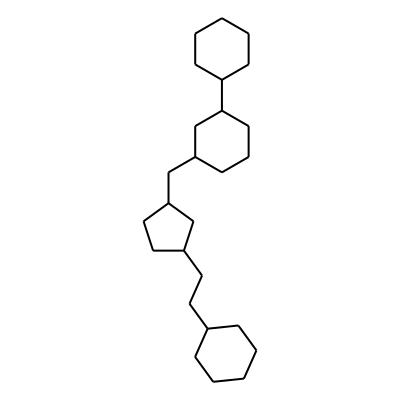
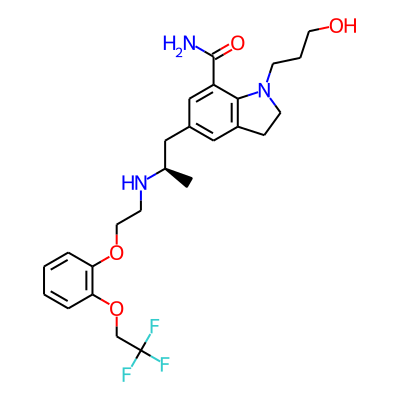
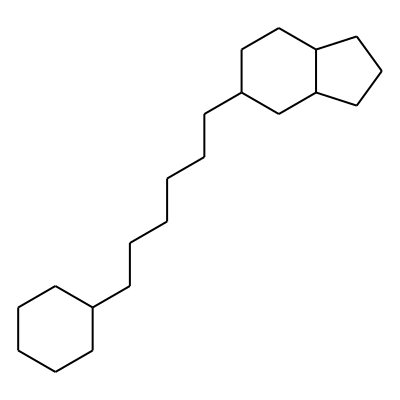

In [70]:
active_drugbank['Scaffold'] = active_drugbank['Molecule'].apply(mol2scaffold)
active_drugbank['Scaffold Smiles'] = active_drugbank['Scaffold'].apply(lambda x: Chem.MolToSmiles(x))
HTML(active_drugbank.head().to_html(formatters={'Molecule': mol2display_png, 'Scaffold': mol2display_png}, escape=False))

,Molecule ChEMBL ID,Molecular Weight,pChEMBL Value,Smiles,Molecule,Activity,Source,Scaffold,Scaffold Smiles
524,CHEMBL2063249,470.32,10.10,O=C(NC1CCCOc2c1nn(-c1ccccc1Cl)c2-c1ccc(Cl)cc1)c1cnon1,,True,Cannabinoid,,C1CCC(C2CC3C(CCC4CCCC4)CCCCC3C2C2CCCCC2)CC1
980,CHEMBL1801352,478.92,9.74,C[C@@H](NC(=O)C1(NC(=O)c2cncnc2)CC1)c1ccc(-n2nc(Cl)c3ccccc32)cc1F,,True,Cannabinoid,,C1CCC(CCC2(CCCC3CCC(C4CCC5CCCCC54)CC3)CC2)CC1
894,CHEMBL1801346,493.93,9.52,C[C@@H](NC(=O)C1(NC(=O)c2cncc(O)c2)CC1)c1ccc(-n2nc(Cl)c3ccccc32)cc1F,,True,Cannabinoid,,C1CCC(CCC2(CCCC3CCC(C4CCC5CCCCC54)CC3)CC2)CC1
895,CHEMBL1801348,495.92,9.43,C[C@@H](NC(=O)C1(NC(=O)c2cncc(F)c2)CC1)c1ccc(-n2nc(Cl)c3ccccc32)cc1F,,True,Cannabinoid,,C1CCC(CCC2(CCCC3CCC(C4CCC5CCCCC54)CC3)CC2)CC1
936,CHEMBL1801341,466.90,9.42,C[C@@H](NC(=O)C1(NC(=O)c2cn[nH]c2)CC1)c1ccc(-n2nc(Cl)c3ccccc32)cc1F,,True,Cannabinoid,,C1CCC(CCC2(CCCC3CCC(C4CCC5CCCCC54)CC3)CC2)C1

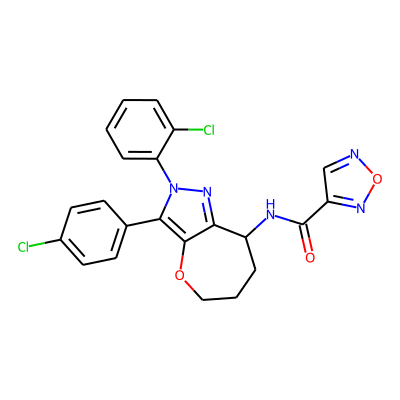
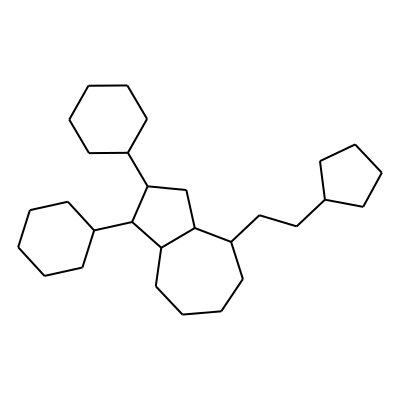
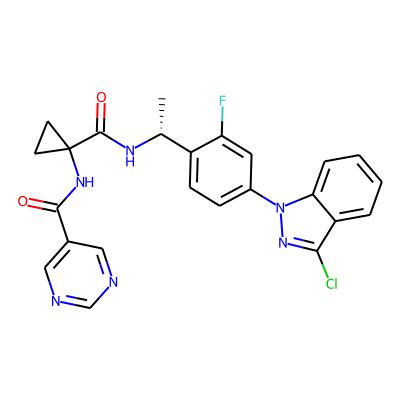
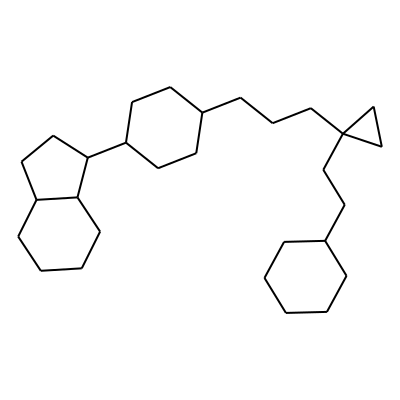
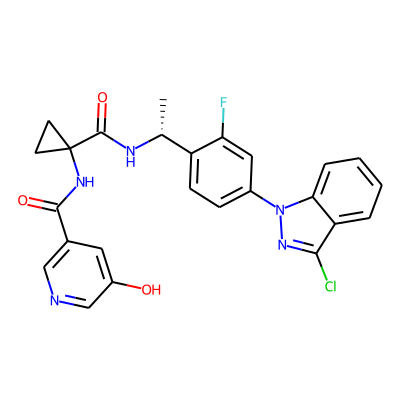
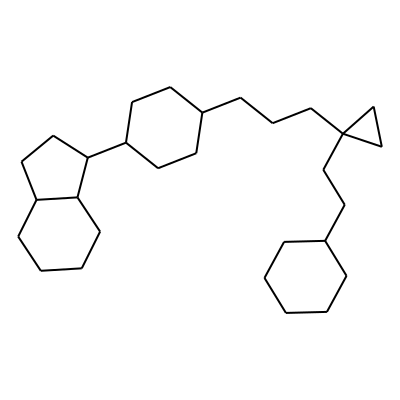
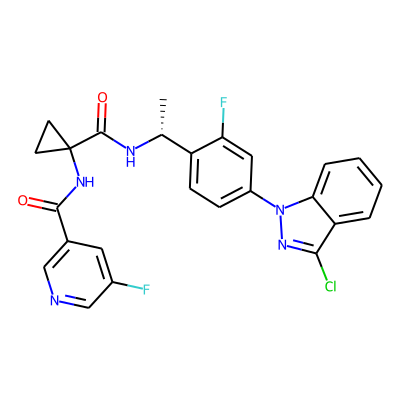
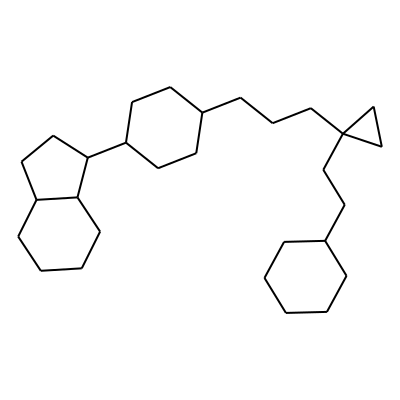
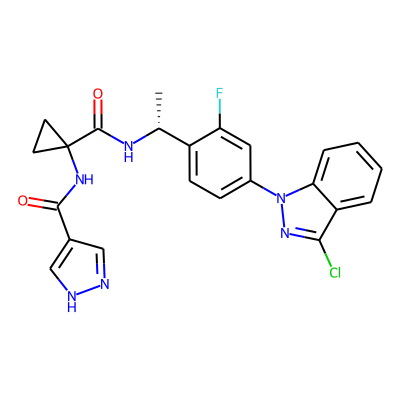
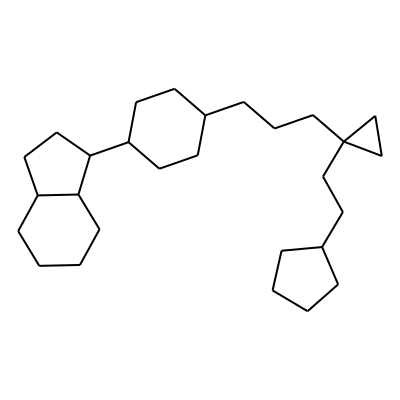

In [71]:
active_cannabinoid['Scaffold'] = active_cannabinoid['Molecule'].apply(mol2scaffold)
active_cannabinoid['Scaffold Smiles'] = active_cannabinoid['Scaffold'].apply(lambda x: Chem.MolToSmiles(x))
HTML(active_cannabinoid.head().to_html(formatters={'Molecule': mol2display_png, 'Scaffold': mol2display_png}, escape=False))